In [1]:
from Learning import *
from Graphing import *

In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("db1,2,4,8,20_all") # Load combo

In [3]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((83549, 26), (83549, 9893), 9893, (20, 126), 126, (83549, 13), (83549, 160))

Shuffle

Construct balanced dataset

In [5]:
meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)
meta, X, X_rec, Yc, Yr = get_balanced_dataset(meta, X, X_rec, Yc, Yr, meta_labels, n_dup=2)
meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

In [6]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((37771, 26), (37771, 6942), 6942, (20, 126), 126, (37771, 13), (37771, 160))

Remove redundant features

In [4]:
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)

In [5]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((47504, 26), (47504, 3781), 3781, (19, 61), 61, (47504, 13), (47504, 160))

Data normalization/feature scaling

In [ ]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales = scale_data(X, X_labels)
Yr_scales = scale_data(Yr, Yr_labels)
print(Yr.min(), X.min(), Yr.max(), X.max())

Remove match duration feature(s) (win prediction use case)

In [ ]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
X.shape

Define experiment models & variables

In [12]:
model_strs = [
    "LogisticRegression",
#     "MLPClassifier",
    "AdaBoostClassifier",
#     "RidgeClassifier",
    "LinearDiscriminantAnalysis",
#     "LinearSVC"
]
y_label = "blue_win"
# n_repeat_runs = 5  # Number of repeat runs to get average over
bucket_perc = 5      # Percentile size for each bucket
n_train = 30000

n_buckets = 100 // bucket_perc
Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)
X_, Y_ = X[:n_train], Y[:n_train]
X_.shape, Y_.shape

((30000, 4182), (30000, 1))

Train models and predict probabilities etc

In [1]:
# res = {}
n_per_bucket = int(0.01 * bucket_perc * X_.shape[0])
for mkey in model_strs:
    arglist = []
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X_, Y_)
    all_test_inds = []
    for train_inds, test_inds in skf.split(X_, Y_):
        all_test_inds += list(test_inds)
        arglist += [(mkey, model_decision_funcs[mkey], X_[train_inds], Y_[train_inds], X_[test_inds])]

    results = Parallel(n_jobs=4, verbose=5)(delayed(test_model_dec)(
        *args) for args in arglist)
    
    for dec_func in model_decision_funcs[mkey]:
        all_res = np.hstack([r[dec_func] for r in results])
    
        probs_classes = np.vstack([all_res, Y_[all_test_inds].flatten()]).T
        inds = np.argsort(probs_classes[:, 0])
        probs_classes = probs_classes[inds]
        
        final_res = []
        i = 0
        for j in range(n_buckets):
            pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
            i += n_per_bucket
            probs, classes = pc[:, 0], pc[:, 1]
            mean_prob = np.mean(probs)
            frac_pos = np.mean(classes)
            final_res += [ [mean_prob, frac_pos] ]

        res[mkey + '_' + dec_func] = np.asarray(final_res).T

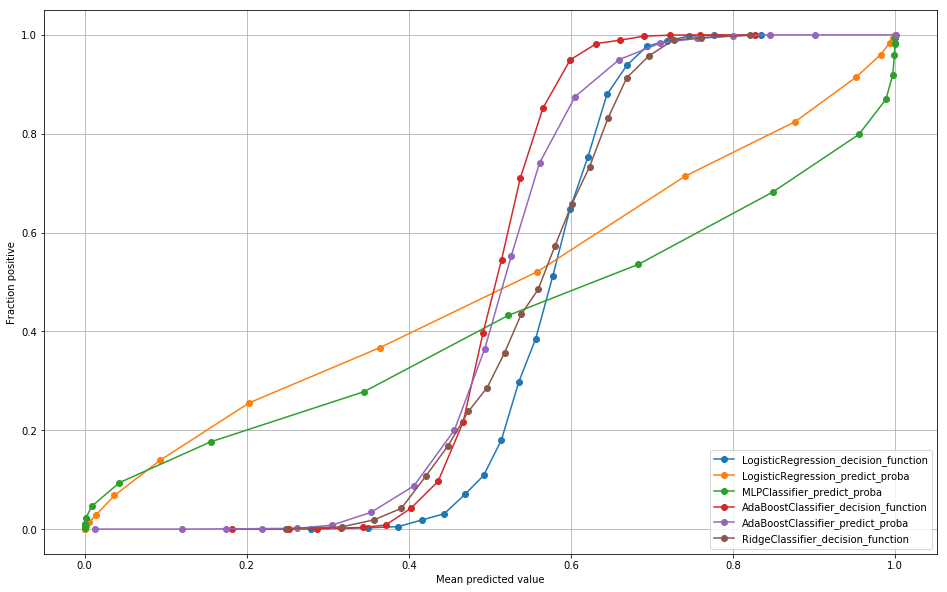

In [23]:
fig = plt.figure()
fig.set_size_inches(16,10)
for k in res:
    r = res[k]
    plt.plot(r[0], r[1], label=k, marker='o')
plt.legend(loc='lower right')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction positive")
plt.grid()
plt.show()

In [13]:
X.shape

(60698, 4182)

In [14]:
n_train = 59000
n_pcal = 0
n_test = 1698
X_train, Y_train, X_pcal, Y_pcal = X[:n_train], Y[:n_train], X[n_train:n_train + n_pcal], Y[n_train:n_train + n_pcal]
X_test, Y_test = X[-n_test:], Y[-n_test:]
X_train.shape, X_pcal.shape, X_test.shape

((59000, 4182), (0, 4182), (1698, 4182))

In [15]:
X_pcal, Y_pcal = X_test, Y_test

In [28]:
class ABCl(AdaBoostClassifier):
    def predict_proba(self, X):
        res = super().predict_proba(X)
        min_ = np.min(res)
        div = np.max(res) - min_
        return (res - min_) / div

In [16]:
# model = ABCl(n_estimators=100)
model = AdaBoostClassifier(n_estimators=100)
# model = LogisticRegression(C=2.78)
# model.fit(X_train[:1000], Y_train[:1000])
model.fit(X_train, Y_train)

c:\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [17]:
# Test accuracy
preds = model.predict(X_test)
np.mean(preds == Y_test.flatten()) * 100 # LR = 85.51236749116607, ADB = 88.751472

89.2226148409894

(array([ 19.,  73., 207., 282., 426., 313., 273.,  88.,  15.,   2.]),
 array([0.46748575, 0.47460752, 0.4817293 , 0.48885107, 0.49597284,
        0.50309461, 0.51021639, 0.51733816, 0.52445993, 0.5315817 ,
        0.53870348]),
 <a list of 10 Patch objects>)

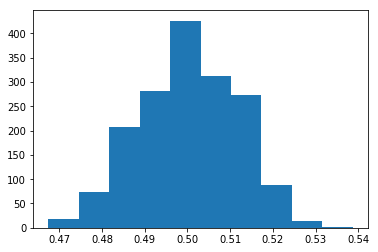

In [18]:
prob_preds = model.predict_proba(X_test)
prob_preds = prob_preds[:, 1]
plt.hist(prob_preds)

In [26]:
c_model = CalibratedClassifierCV(base_estimator=model, cv="prefit", method='sigmoid')
c_model.fit(X_pcal, Y_pcal)

c:\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None),
            cv='prefit', method='sigmoid')

In [27]:
# Test accuracy
c_preds = c_model.predict(X_test)
np.mean(c_preds == Y_test.flatten()) * 100

89.34040047114252

In [28]:
prob_preds = c_model.predict_proba(X_test)
prob_preds = prob_preds[:, 1]

In [29]:
# prob_preds = (prob_preds - min(prob_preds)) / (max(prob_preds) - min(prob_preds))
probs_classes = np.vstack([prob_preds, Y_test.flatten()]).T
inds = np.argsort(probs_classes[:, 0])
probs_classes = probs_classes[inds]

final_res = []
i = 0
n_per_bucket = int(0.01 * bucket_perc * probs_classes.shape[0])
for j in range(n_buckets):
    pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
    i += n_per_bucket
    probs, classes = pc[:, 0], pc[:, 1]
    mean_prob = np.mean(probs)
    frac_pos = np.mean(classes)
    final_res += [ [mean_prob, frac_pos] ]

array([ 89.4,   1.3,  99.4,  21.1,  85.4,  99.6,   0.1,   0.1,  97.7,
         0.8,  59.1,  41.3,  97. ,  90.4,  58.5,  97. ,  63.3,   0.7,
         4.7,  98.3,   2.3,   0.1,  53.5,  98.9,  29. ,   1.4,   0.2,
       100. ,  61.4,  93.3,  99.5,   3.2,   0. ,   0. ,  18.5,  34.6,
        99.9,   0.3,   1.6, 100. ,   5.4,  98.8,  96.2,  85.4,  93.1,
        95.8,   0. ,   2.8,   9.6,  11.9,  99.7,  43.4,  99.7,  87.6,
        28. ,   1.7,   0. ,   0. ,   0.8,  35.4,  82.2,  83.8,  92.7,
        98.9,  13.5,   5. ,  36. ,  34.5,  98.1,  43. ,  99.9,   6.1,
         0.2,  99.5,  99.1,   8. , 100. ,  51.3,   3.1,  92.4,   5.5,
        20.2,  99.4,  96.6,  99.6,  72.4,  94.8,  97.3,   0. ,  10.4,
        98.8,  99.4,  89. ,  81. ,  66.8,   0.6,  99.5,  99.9, 100. ,
         0. ])

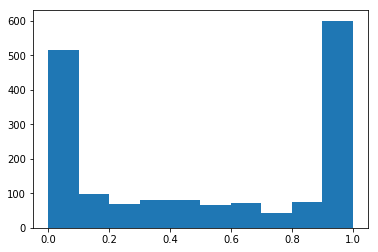

In [30]:
plt.hist(prob_preds)
np.round(prob_preds[:100] * 100, 1)

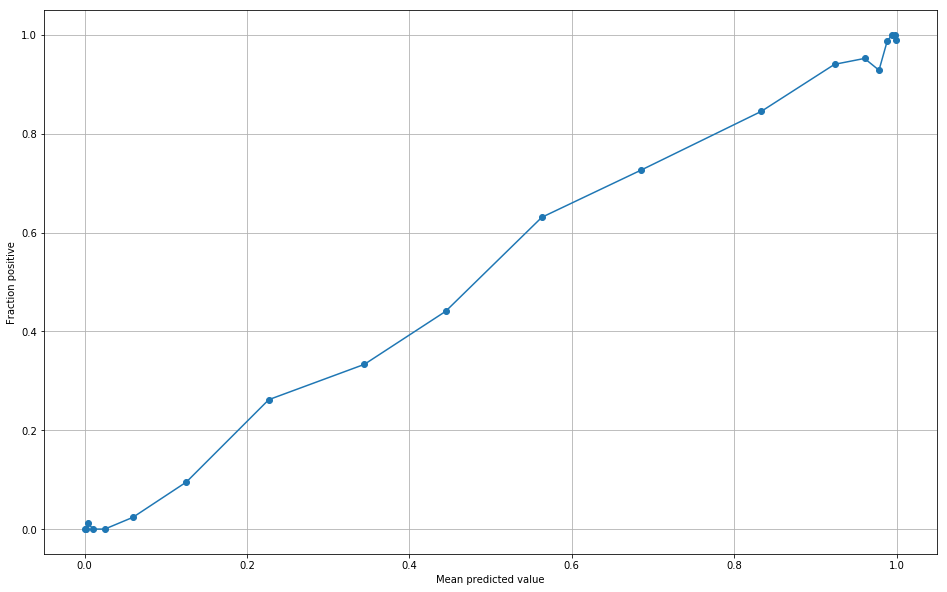

In [31]:
fig = plt.figure()
fig.set_size_inches(16, 10)
r = np.asarray(final_res).T
plt.plot(r[0], r[1], marker='o')
# plt.legend(loc='lower right')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction positive")
plt.grid()
plt.show()

(array([1035., 1538., 1664., 1800., 1665., 3007., 2379., 2283., 2278.,
        2017., 2548., 2188., 2220., 2047., 2038., 2431., 2103., 2124.,
        2171., 1819., 3013., 2588., 3117., 3463., 3378., 2250., 1534.]),
 array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
         4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
         9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
        14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
        19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
        24.07407407, 25.03703704, 26.        ]),
 <a list of 27 Patch objects>)

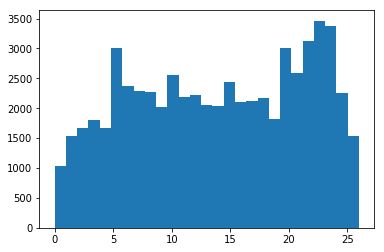

In [25]:
plt.hist(meta[:, meta_labels.index('division')], bins=27)

In [4]:
def one_side_data(meta, X, X_rec, Yc, Yr,
        meta_labels, X_labels, X_rec_labels, Yc_labels, Yr_labels):
    sides_is = np.random.randint(0, 2, X.shape[0])
    swap_is = np.nonzero(sides_is)[0]
    blue_is = [i for i in range(len(X_labels)) if X_labels[i][:5] == "blue_"]

    rem_lis = []
    X_ = X[:]
    for i in range(len(blue_is)):
        l = X_labels[blue_is[i]]
        red_i = X_labels.index("red_" + l[5:])
        X_[swap_is, blue_is[i]] = X[swap_is, red_i]

        rem = False
        for j in range(1, 21):
            if "_" + str(j) + "avg_" in l:
                rem = True
                break
        if not rem:
            for l_ in one_side_rem_feats_player:
                if l_ in l:
                    rem = True
                    break
        if rem:
            rem_lis.append(red_i)
        else:
            X_[swap_is, red_i] = X[swap_is, blue_is[i]]

    for l in one_side_rem_feats:
        rem_lis.append(X_labels.index(l))

    X_ = np.delete(X_, rem_lis, axis=1)

    X_labels_ = [X_labels[i] for i in range(len(X_labels)) if i not in rem_lis]
    for i in range(len(X_labels_)):
        if X_labels_[i][:5] == "blue_":
            X_labels_[i] = "friendly_" + X_labels_[i][5:]
        elif X_labels_[i][:4] == "red_":
            X_labels_[i] = "opponent_" + X_labels_[i][4:]

    blue_win_i = Yc_labels.index("blue_win")
    Yc_ = Yc[:]
    Yc_[swap_is, blue_win_i] = 1 - Yc_[swap_is, blue_win_i]
    
    # Add side (blue or red) as feature
    side_feat = np.atleast_2d(sides_is).T
    X_ = np.hstack([1 - side_feat, side_feat, X_]) # blue side = [1, 0], red side = [0, 1]
    X_labels_ = ["friendly_side__x1", "friendly_side__x2"] + X_labels_

    return X_, Yc_, X_labels_

In [5]:
X, Yc, X_labels = one_side_data(meta, X, X_rec, Yc, Yr,
        meta_labels, X_labels, X_rec_labels, Yc_labels, Yr_labels)

In [6]:
sum(Yc[:, 0] == 1), X.shape, len(X_labels)

(30705, (60698, 4183), 4183)